# Stress drops!

In [1]:
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr

from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib.pyplot as plt

import json
import blue_ice_tools as bit
import itslivetools

import imageio
import warnings
warnings.filterwarnings("ignore")

## Load in Full Dataset with Fracture

In [2]:
# Read in shapefile of Shirase Glacier
shirase_shape = gpd.read_file('../data/shirase-glacier/shirase.shp')
fracture = xr.open_dataset('../data/shirase-glacier/shirase-fracture-clipped.nc')

# Load in ITS_LIVE velocities with shape
shirase_dc = bit.get_data_cube(shape=shirase_shape, epsg=3031, dt_delta=18, start_date='2018-07-01')

# Limit stress to dates of fracture maps, compute
shirase_dc = shirase_dc.sel(mid_date=slice(fracture.mid_date[0], fracture.mid_date[-1]))

# Call stress function
shirase_stress = bit.compute_strain_stress(shirase_dc, rotate=True, sav_gol=True)

# Merge datasets
shirase_ds = xr.merge([fracture, shirase_stress]).compute()
shirase_ds

Computing stresses       : 100%|██████████| 1/1 [00:00<00:00, 44.88it/s]


<xarray.Dataset> Size: 473MB
Dimensions:        (mid_date: 55, x: 328, y: 655)
Coordinates:
  * mid_date       (mid_date) datetime64[ns] 440B 2018-07-31 ... 2023-01-31
  * x              (x) float64 3kB 1.344e+06 1.344e+06 ... 1.383e+06 1.384e+06
  * y              (y) float64 5kB 1.649e+06 1.65e+06 ... 1.728e+06 1.728e+06
    spatial_ref    int64 8B 0
    mapping        int64 8B 0
Data variables:
    fracture_conf  (mid_date, y, x) float64 95MB nan nan nan nan ... nan nan nan
    vx             (mid_date, y, x) float32 47MB nan nan nan nan ... nan nan nan
    vy             (mid_date, y, x) float32 47MB nan nan nan nan ... nan nan nan
    effective      (mid_date, y, x) float32 47MB nan nan nan nan ... nan nan nan
    eps_xx         (mid_date, y, x) float32 47MB nan nan nan nan ... nan nan nan
    eps_yy         (mid_date, y, x) float32 47MB nan nan nan nan ... nan nan nan
    von_mises      (mid_date, y, x) float32 47MB nan nan nan nan ... nan nan nan
    sigma1         (mid_date, y, x) float32 47MB nan nan nan nan ... nan nan nan
    sigma2         (mid_date, y, x) float32 47MB nan nan nan nan ... nan nan nan

## Processing Stress Drops

Following earthquake rupture mechanics, we can quantify fracture by watching the change in stress after the fracture event. 

To do this, we need to identify when a parcel actually becomes crevassed. Our first parcel to track is at (x, y) = (1365000, 1714200). It was identified at time index 28.

Let's plot this parcel to get an idea of where it is located

In [3]:
x = 1365000        # X-coord
y = 1714200        # Y-coord
start_index = 28   # time index of location

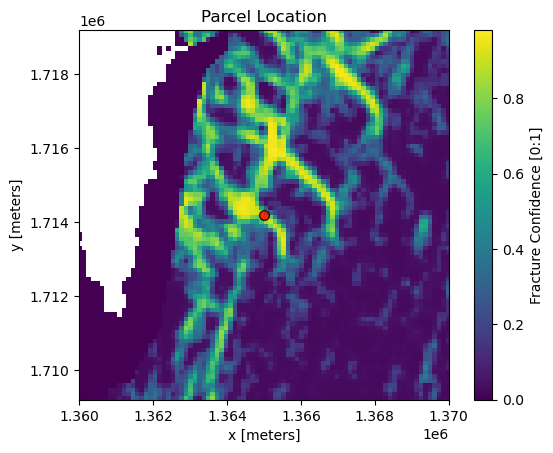

In [4]:
fig, ax =plt.subplots()

# Fracture map on the date with parcel location
shirase_ds.fracture_conf[start_index].plot(ax=ax, cbar_kwargs={'label':'Fracture Confidence [0:1]'})
ax.scatter(x, y, c='r', s=50, ec='k', alpha=0.8)

ax.set_xlim([x-5000, x+5000])  # set x-bounds to range of 10000 meters
ax.set_ylim([y-5000, y+5000])  # set y-bounds to range of 10000 meters

ax.set_title('Parcel Location')
ax.set_xlabel('x [meters]')
ax.set_ylabel('y [meters]')
ax.set_aspect('equal')

This parcel is on a the front portion of a large crevasse up on the tongue of the glacier. We are going to pass this to `bit.parcel_strain_stress()`, which requires a buffer. 

The buffer is the distance in the positive and negative x- and y-directions to average values across. This can help reduce noise in the timeseries.

### Buffer Choices

Below, I will plot a handful of different buffer values to identify the best option for this parcel.

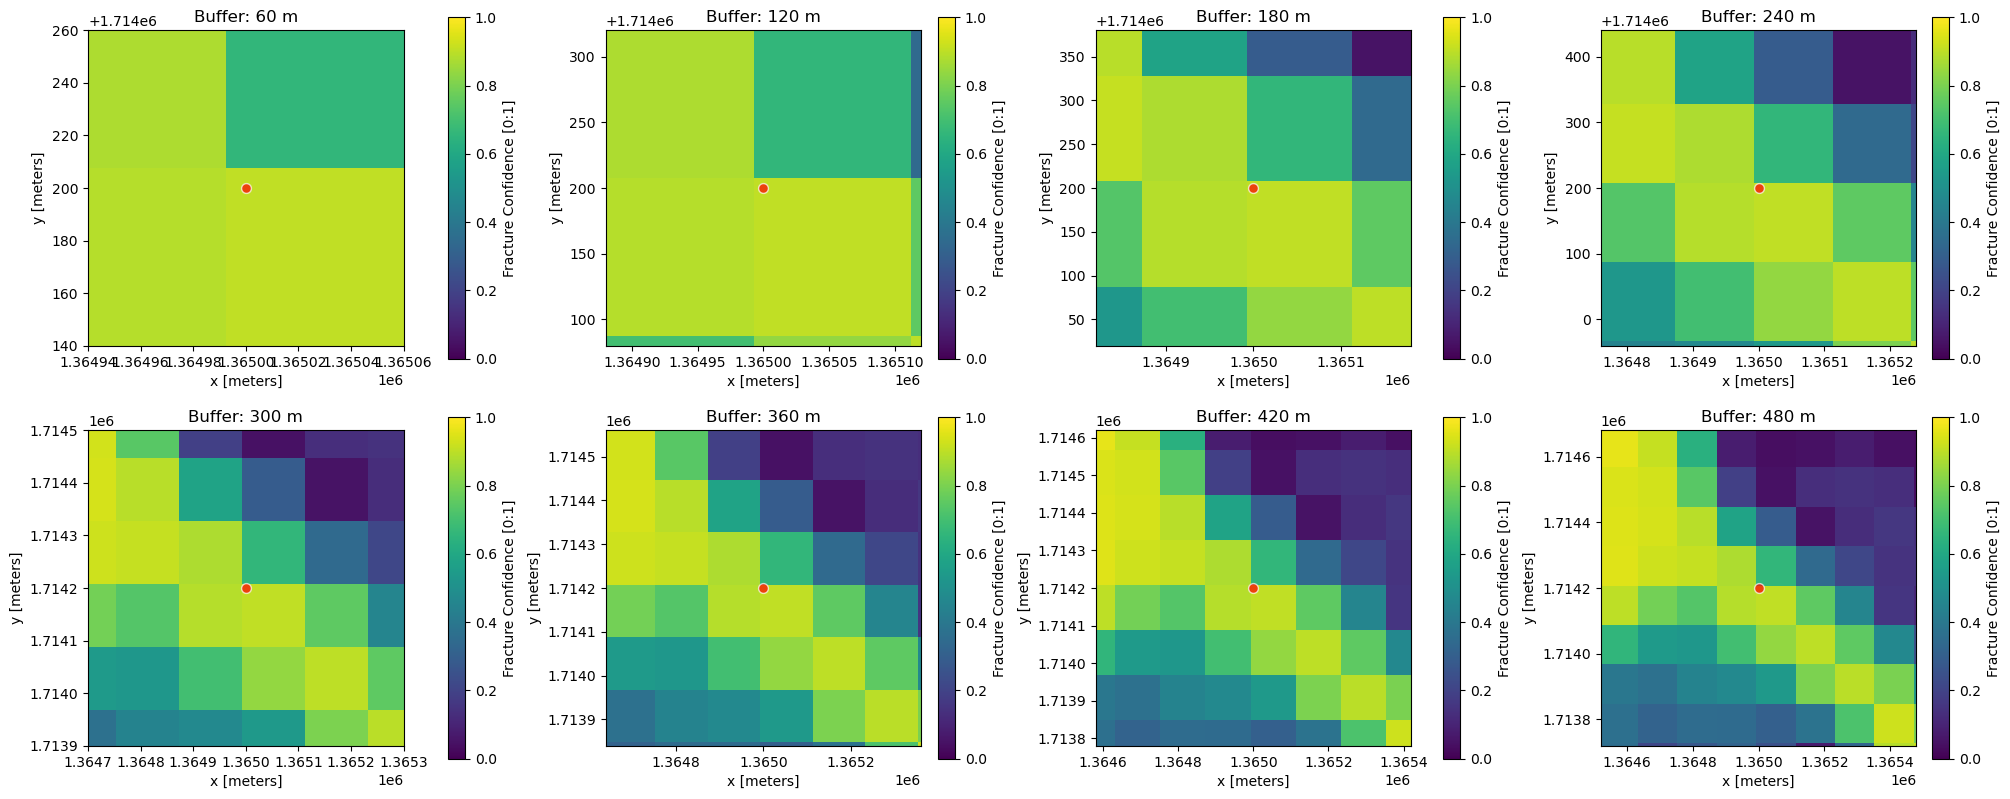

In [5]:
fig, axs = plt.subplots(ncols=4, nrows=2, layout='constrained', figsize=(20,8))
axs = axs.flatten()

# List of buffer values
buffers = [x for x in range(60, 481, 60)]

# Plot map on each subplots
for ax, buffer in zip(axs, buffers):
    shirase_ds.fracture_conf[start_index].plot(ax=ax, cbar_kwargs={'label':'Fracture Confidence [0:1]'}, vmin=0, vmax=1)
    ax.scatter(x, y, c='r', ec='w', alpha=0.7, s=50)
    ax.set_xlim([x-buffer, x+buffer])
    ax.set_ylim([y-buffer, y+buffer])

    ax.set_title(f'Buffer: {buffer} m')
    ax.set_xlabel('x [meters]')
    ax.set_ylabel('y [meters]')
    ax.set_aspect('equal')

Finding here that averaging over larger areas brings uncrevassed cells into the average, which could affect how we pick our "crevasse opening".

I like the buffer size of 120 meters the best. IT brings a handful of cells together without drawing in uncrevassed cells.

## Track Parcel 1

In [6]:
parcel1, pts1 = bit.parcel_strain_stress(shirase_ds, x, y, buffer=120, 
                                         start_index=start_index, steps_reverse=start_index, 
                                         filtersize=2)

Tracking Parcel: 100%|██████████| 55/55 [00:00<00:00, 391.67it/s]


Watch the parcel for breakage:

Easiest with a GIF probably?

In [7]:
xmax, ymax = pts1.max(axis=0)
xmin, ymin = pts1.min(axis=0)

for i in range(len(parcel1.mid_date)):    
    fig, ax = plt.subplots(dpi=300, figsize=(3.5,5))

    shirase_ds.fracture_conf[i].plot(ax=ax, cbar_kwargs={'label':'Fracture Confidence [0:1]'}, vmin=0, vmax=1)
    ax.scatter(pts1[i][0], pts1[i][1], c='r', ec='w', alpha=0.25)

    ax.set_xlim(xmin-1000, xmax+1000)
    ax.set_ylim(ymin-1000, ymax+1000)
    ax.set_aspect('equal')

    ax.set_title(f"{np.datetime64(parcel1.mid_date[i].data, 'D')}")
    ax.set_xlabel('x [meters]')
    ax.set_ylabel('y [meters]')

    plt.savefig(f'../figures/gif-pngs/05-p1-{i}.png')
    plt.close()

pngs = [imageio.v2.imread(f'../figures/gif-pngs/05-p1-{i}.png') for i in range(len(parcel1.mid_date))]

imageio.mimsave('../figures/shirase-glacier/05-p1.gif', pngs, duration=1000, loop=0)

<figure>
    <img src='../figures/shirase-glacier/05-p1.gif' width=500>
</figure>

It appears that the parcel fractures right around December of 2019. The cells around the parcel appear to shade light green before jumping to a brighter yellow. I believe the fracture does actually open at the large jump.

Let's see what the fracture confidence is at that time:

In [8]:
dec_2019 = parcel1.sel(mid_date=np.datetime64('2019-12-31'))

print(f"Parcel fracture confidence on 2019-12-31:      {dec_2019.fracture_conf.data * 100:.3f}%")

Parcel fracture confidence on 2019-12-31:      81.677%


This parcel, we'll call it Parcel 1, opens at a fracture confidence of 81.677%.

It may help to characterize how this fracture progresses. Did the confidence slowly rise over a dozen months, or did it immediately jump to the high fracture threshold?

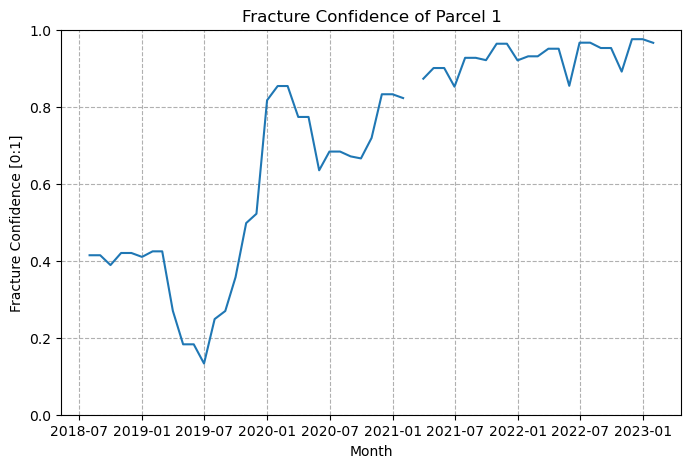

In [9]:
fig, ax = plt.subplots(figsize=(8,5), dpi=100)

ax.plot(parcel1.mid_date, parcel1.fracture_conf)
ax.set_ylabel('Fracture Confidence [0:1]')
ax.set_xlabel('Month')
ax.set_ylim([0,1])
ax.grid(ls='--')

ax.set_title('Fracture Confidence of Parcel 1')
plt.show()

Let's see how this looks with another parcel and see what the fracture confidence looks like when it fractures. If after a few parcels, the type of fracture confidence progression and the confidence values start to agree, we can think about automating the selection process.

## Parcel Gif Function

We're going to make a function for the GIF process to make things run faster:

In [10]:
def parcel_gif(ds, parcel, pts, parcel_no):
    xmax, ymax = pts.max(axis=0)
    xmin, ymin = pts.min(axis=0)
    
    for i in range(len(parcel.mid_date)):    
        fig, ax = plt.subplots(dpi=300, figsize=(3.5,5))
    
        shirase_ds.fracture_conf[i].plot(ax=ax, cbar_kwargs={'label':'Fracture Confidence [0:1]'}, vmin=0, vmax=1)
        ax.scatter(pts[i][0], pts[i][1], c='r', ec='w', alpha=0.25)
    
        ax.set_xlim(xmin-1000, xmax+1000)
        ax.set_ylim(ymin-1000, ymax+1000)
        ax.set_aspect('equal')
    
        ax.set_title(f"{np.datetime64(parcel.mid_date[i].data, 'D')}")
        ax.set_xlabel('x [meters]')
        ax.set_ylabel('y [meters]')
    
        plt.savefig(f'../figures/gif-pngs/05-p{parcel_no}-{i}.png')
        plt.close()
    
    pngs = [imageio.v2.imread(f'../figures/gif-pngs/05-p{parcel_no}-{i}.png') for i in range(len(parcel.mid_date))]
    
    imageio.mimsave(f'../figures/shirase-glacier/05-p{parcel_no}.gif', pngs, duration=1000, loop=0)

## Track Parcel 2

Parcel 2 is on the same crevasse as parcel 1, but further inside. This area of the crevasse opens later than the original parcel. It is located at (x, y) = (1365500, 1713500) and was identified at timestep 28, as well.

In [11]:
x = 1365500
y = 1713500

start_index=28
buffer = 120

parcel2, pts2 = bit.parcel_strain_stress(shirase_ds, x, y, buffer=buffer, start_index=start_index, steps_reverse=start_index)

Tracking Parcel: 100%|██████████| 55/55 [00:00<00:00, 356.15it/s]


In [12]:
parcel_gif(shirase_ds, parcel2, pts2, 2)

<figure>
    <img src='../figures/shirase-glacier/05-p2.gif' width=500>
</figure>

Tbh, kind of hard to tell what's happening here... Let's plot the frac conf thru time to see if there's any insight

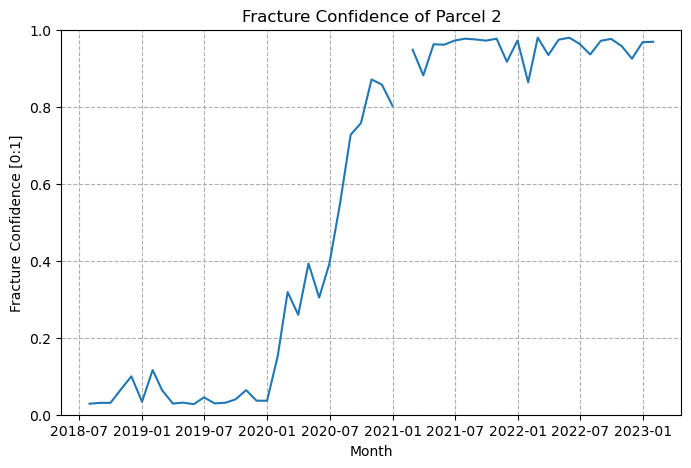

In [13]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(parcel2.mid_date, parcel2.fracture_conf)
ax.set_ylabel('Fracture Confidence [0:1]')
ax.set_xlabel('Month')
ax.set_ylim([0,1])
ax.grid(ls='--')

ax.set_title('Fracture Confidence of Parcel 2')
plt.show()

Okay, interesting. By looking at this, you would expect a crevasse opening somewhere between October 2020 and January 2021.

## Track Parcel 3

Now let's try a third parcel, this time from a separate crevasse. PArcel 3 is located at (x, y) = (1365800, 1715500) and was also identified on timestep 28.

In [14]:
x = 1365800
y = 1715500

start_index = 28
buffer = 120

parcel3, pts3 = bit.parcel_strain_stress(shirase_ds, x, y, buffer=buffer, start_index=start_index, steps_reverse=start_index)

Tracking Parcel: 100%|██████████| 55/55 [00:00<00:00, 383.64it/s]


In [15]:
parcel_gif(shirase_ds, parcel3, pts3, 3)

<figure>
    <img src='../figures/shirase-glacier/05-p3.gif' width=500>
</figure>

This parcel appears to open in late 2019, with a much more gradual trajectory. Let's look at that below:

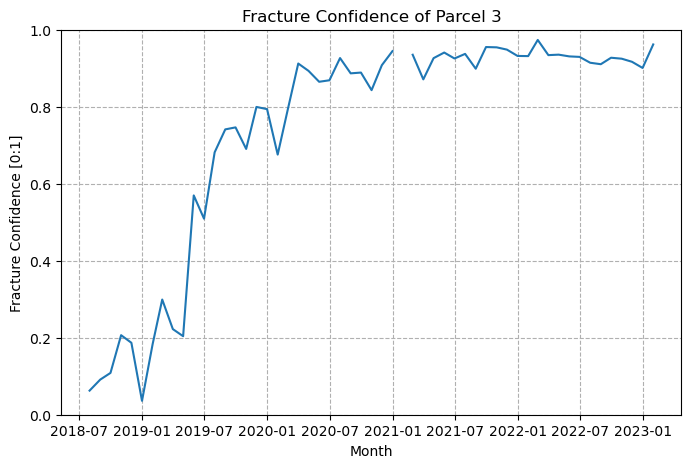

In [16]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(parcel3.mid_date, parcel3.fracture_conf)
ax.set_ylabel('Fracture Confidence [0:1]')
ax.set_xlabel('Month')
ax.set_ylim([0,1])
ax.grid(ls='--')

ax.set_title('Fracture Confidence of Parcel 3')
plt.show()

## Track Parcel 4

NEXT:

In [17]:
x = 1371500
y = 1715200

start_index=28

parcel4, pts4 = bit.parcel_strain_stress(shirase_ds, x, y, buffer=buffer, start_index=start_index, steps_reverse=start_index)

Tracking Parcel: 100%|██████████| 55/55 [00:00<00:00, 104.27it/s]


In [18]:
parcel_gif(shirase_ds, parcel4, pts4, 4)

<figure>
    <img src='../figures/shirase-glacier/05-p4.gif' width=500>
</figure>

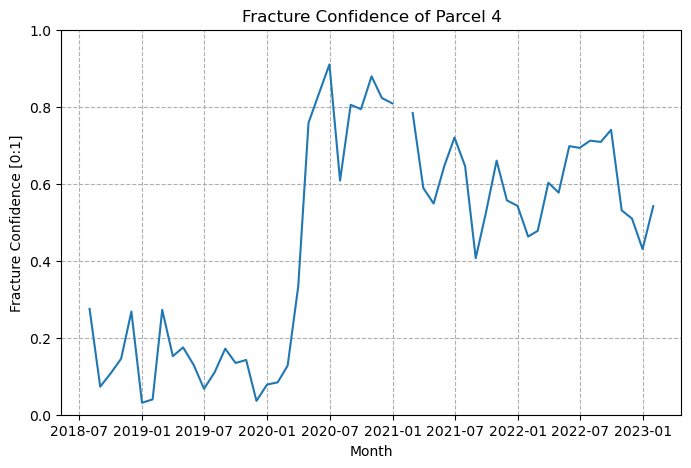

In [19]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(parcel4.mid_date, parcel4.fracture_conf)
ax.set_ylabel('Fracture Confidence [0:1]')
ax.set_xlabel('Month')
ax.set_ylim([0,1])
ax.grid(ls='--')

ax.set_title('Fracture Confidence of Parcel 4')
plt.show()

## Track Parcel 5

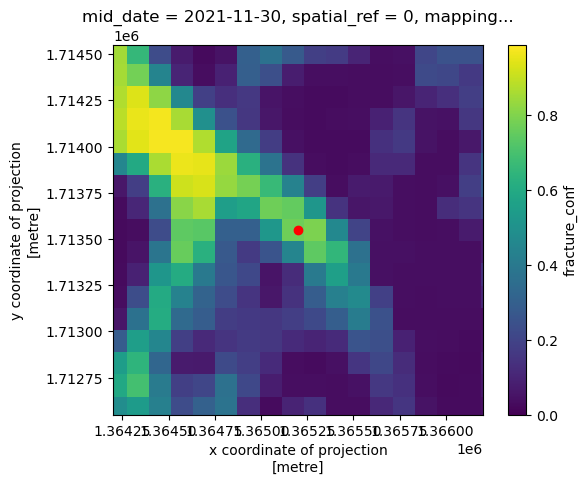

In [20]:
x = 1.3652e6
y = 1.71355e6
start_index = 40

shirase_ds.fracture_conf[start_index].plot()
plt.scatter(x, y, c='r')

plt.xlim([x-1000, x+1000])
plt.ylim([y-1000, y+1000])
plt.gca().set_aspect('equal')

In [21]:
parcel5, pts5 = bit.parcel_strain_stress(shirase_ds, x, y, buffer=buffer, start_index=start_index, steps_reverse=start_index)

Tracking Parcel: 100%|██████████| 55/55 [00:00<00:00, 355.29it/s]


In [22]:
parcel_gif(shirase_ds, parcel5, pts5, 5)

<figure>
    <img src="../figures/shirase-glacier/05-p5.gif" width=400 />
</figure>

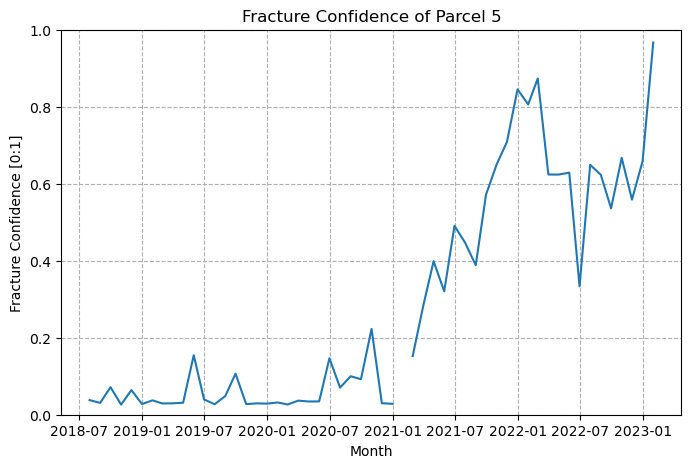

In [23]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(parcel5.mid_date, parcel5.fracture_conf)
ax.set_ylabel('Fracture Confidence [0:1]')
ax.set_xlabel('Month')
ax.set_ylim([0,1])
ax.grid(ls='--')

ax.set_title('Fracture Confidence of Parcel 5')
plt.show()

## Track Parcel 6

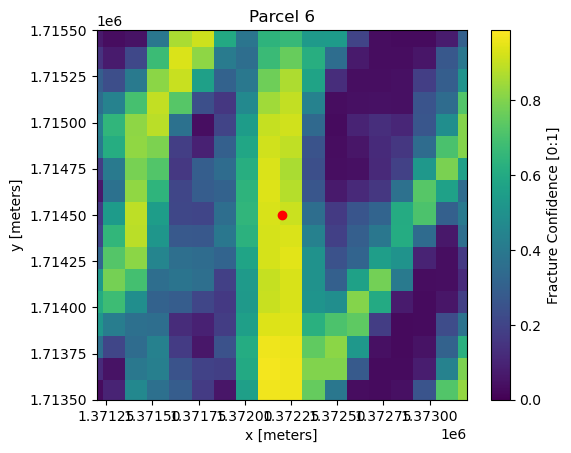

In [24]:
x = 1.3722e6
y = 1.7145e6
start_index = 40

shirase_ds.fracture_conf[start_index].plot(cbar_kwargs={'label':'Fracture Confidence [0:1]'})
plt.scatter(x, y, c='r')

# plt.xlim([1.3605e6, 1.38e6])
# plt.ylim([1.705e6, 1.73e6])
plt.xlim([x-1000, x+1000])
plt.ylim([y-1000, y+1000])
plt.xlabel('x [meters]')
plt.ylabel('y [meters]')
plt.title('Parcel 6')
plt.gca().set_aspect('equal')

In [25]:
parcel6, pts6 = bit.parcel_strain_stress(shirase_ds, x, y, buffer=buffer, start_index=start_index, steps_reverse=start_index)

Tracking Parcel: 100%|██████████| 55/55 [00:00<00:00, 354.41it/s]


In [26]:
parcel_gif(shirase_ds, parcel6, pts6, 6)

<figure>
    <img src="../figures/shirase-glacier/05-p6.gif" width=400 />
</figure>

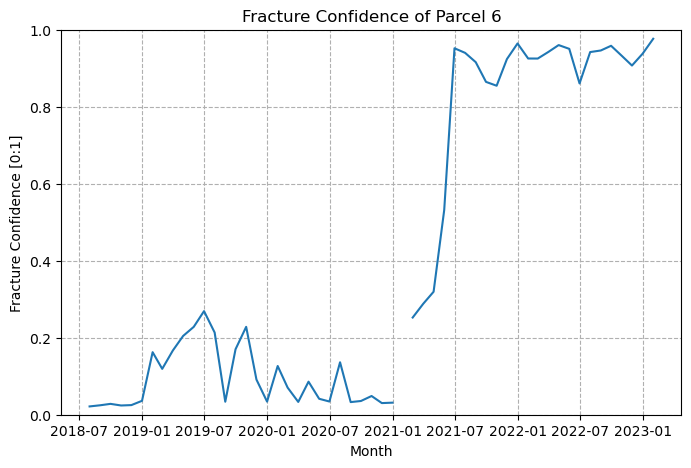

In [27]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(parcel6.mid_date, parcel6.fracture_conf)
ax.set_ylabel('Fracture Confidence [0:1]')
ax.set_xlabel('Month')
ax.set_ylim([0,1])
ax.grid(ls='--')

ax.set_title('Fracture Confidence of Parcel 6')
plt.show()

## Determining "Fractured" Ice

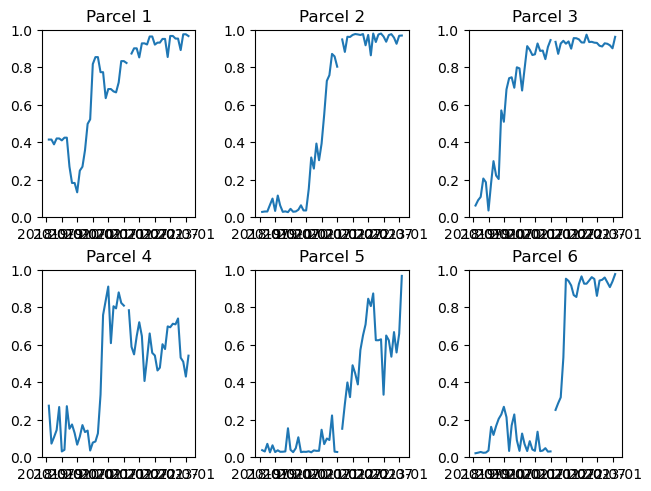

In [29]:
parcels = [parcel1, parcel2, parcel3, parcel4, parcel5, parcel6]

fig, axs = plt.subplots(2, 3, layout='constrained')

for i, (ax, parcel) in enumerate(zip(axs.flatten(), parcels)):
    ax.plot(parcel.mid_date, parcel.fracture_conf)
    ax.set_ylim(0,1)
    ax.set_title(f"Parcel {i+1}")

After this visual inspection, we have come to the conclusion that fracture confidences greater than 60% are fractured ice. 